In [7]:
def gini_impurity(node):
    """
    Calculates the Gini impurity of a node in a decision tree.
    
    Parameters:
        node (list or tuple): a list or tuple containing the counts of each class in the node
        
    Returns:
        float: the Gini impurity of the node
    """
    n = sum(node)
    if n == 0:
        return 0
    impurity = 1
    for class_count in node:
        p = class_count / n
        impurity -= p ** 2
    return impurity


In [6]:
# Example 1
node1 = [15, 15]
print("Example 1 - Expected: 0.5 / Calculated: ", gini_impurity(node1))

# Example 2
node2 = [15, 15, 15]
print("Example 2 - Expected: 0.667 / Calculated: ", gini_impurity(node2))

# Example 3
node3 = [18, 12]
print("Example 3 - Expected: 0.48 / Calculated: ", gini_impurity(node3))

# Example 4
node4 = [30, 0]
print("Example 4 - Expected: 0.0 / Calculated: ", gini_impurity(node4))


Example 1 - Expected: 0.5 / Calculated:  0.5
Example 2 - Expected: 0.667 / Calculated:  0.6666666666666665
Example 3 - Expected: 0.48 / Calculated:  0.48
Example 4 - Expected: 0.0 / Calculated:  0.0


In [8]:
def information_gain(parent_node, left_node, right_node):
    """
    Calculates the information gain of a split between a parent node and two child nodes.
    
    Parameters:
        parent_node (list or tuple): a list or tuple containing the counts of each class in the parent node
        left_node (list or tuple): a list or tuple containing the counts of each class in the left child node
        right_node (list or tuple): a list or tuple containing the counts of each class in the right child node
    
    Returns:
        float: the information gain of the split
    """
    parent_impurity = gini_impurity(parent_node)
    left_impurity = gini_impurity(left_node)
    right_impurity = gini_impurity(right_node)
    n_parent = sum(parent_node)
    n_left = sum(left_node)
    n_right = sum(right_node)
    gain = parent_impurity - ((n_left / n_parent) * left_impurity) - ((n_right / n_parent) * right_impurity)
    return gain


In [9]:
# Example
parent_node = [30, 35]
left_node = [10, 30]
right_node = [20, 5]
print("Example - Expected: 0.143 / Calculated: ", information_gain(parent_node, left_node, right_node))


Example - Expected: 0.143 / Calculated:  0.14319526627218943


In [11]:
import numpy as np

class Node:
    def __init__(self, depth=0, max_depth=2, min_samples_leaf=1):
        self.depth = depth
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.feature_idx = None
        self.threshold = None
        self.left_child = None
        self.right_child = None
        self.label = None
        self.impurity = None

    def fit(self, X, y):
        # Set label to majority class in case of pure node
        self.label = np.argmax(np.bincount(y))
        self.impurity = 1.0 - np.max(np.bincount(y) / len(y))

        # Check stopping criteria
        if self.impurity == 0.0 or self.depth == self.max_depth or len(X) < self.min_samples_leaf:
            return

        # Find best split
        best_feature_idx, best_threshold, best_ig = self._get_best_split(X, y)

        # Split data
        left_idx = X[:, best_feature_idx] <= best_threshold
        right_idx = X[:, best_feature_idx] > best_threshold
        self.feature_idx = best_feature_idx
        self.threshold = best_threshold

        # Recurse on left and right nodes
        self.left_child = Node(depth=self.depth+1, max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf)
        self.left_child.fit(X[left_idx], y[left_idx])

        self.right_child = Node(depth=self.depth+1, max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf)
        self.right_child.fit(X[right_idx], y[right_idx])

    def predict(self, X):
        if self.impurity == 0.0:
            return self.label
        elif X[self.feature_idx] <= self.threshold:
            return self.left_child.predict(X)
        else:
            return self.right_child.predict(X)

    def _get_best_split(self, X, y):
        best_feature_idx = None
        best_threshold = None
        best_ig = -np.inf
        for feature_idx in range(X.shape[1]):
            for threshold in X[:, feature_idx]:
                left_idx = X[:, feature_idx] <= threshold
                right_idx = X[:, feature_idx] > threshold
                if len(y[left_idx]) == 0 or len(y[right_idx]) == 0:
                    continue
                ig = self._information_gain(y, y[left_idx], y[right_idx])
                if ig > best_ig:
                    best_feature_idx = feature_idx
                    best_threshold = threshold
                    best_ig = ig
        return best_feature_idx, best_threshold, best_ig

    def _information_gain(self, y, y_left, y_right):
        p = len(y_left) / len(y)
        left_impurity = 1.0 - np.max(np.bincount(y_left) / len(y_left))
        right_impurity = 1.0 - np.max(np.bincount(y_right) / len(y_right))
        return self.impurity - p * left_impurity - (1.0 - p) * right_impurity


In [12]:
class ScratchDecisionTreeClassifierDepth1:
    def __init__(self, max_depth=1):
        self.max_depth = max_depth
        self.threshold = None
        self.feature_index = None
        self.left_label = None
        self.right_label = None

    def fit(self, X, y):
        max_ig = -1
        for i in range(X.shape[1]):
            for threshold in X[:, i]:
                left_label = y[X[:, i] <= threshold]
                right_label = y[X[:, i] > threshold]
                ig = self._information_gain(y, left_label, right_label)
                if ig > max_ig:
                    max_ig = ig
                    self.threshold = threshold
                    self.feature_index = i
                    self.left_label = np.argmax(np.bincount(left_label))
                    self.right_label = np.argmax(np.bincount(right_label))

    def predict(self, X):
        if self.left_label == self.right_label:
            return self.left_label
        else:
            return np.where(X[:, self.feature_index] <= self.threshold, self.left_label, self.right_label)

    def _gini_impurity(self, y):
        classes, counts = np.unique(y, return_counts=True)
        p = counts / len(y)
        impurity = 1 - np.sum(p ** 2)
        return impurity

    def _information_gain(self, parent, left_child, right_child):
        ig = self._gini_impurity(parent)
        ig -= len(left_child) / len(parent) * self._gini_impurity(left_child)
        ig -= len(right_child) / len(parent) * self._gini_impurity(right_child)
        return ig


In [13]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

# Load the dataset
data = load_breast_cancer()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.2, random_state=42)


In [14]:
# Train the model
tree = ScratchDecisionTreeClassifierDepth1(max_depth=1)
tree.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = tree.predict(X_test)

# Evaluate the model's performance
from sklearn.metrics import accuracy_score, precision_score, recall_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))


Accuracy: 0.8859649122807017
Precision: 0.9393939393939394
Recall: 0.8732394366197183


In [15]:
from sklearn.tree import DecisionTreeClassifier

# Train the model
dt = DecisionTreeClassifier(max_depth=1)
dt.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = dt.predict(X_test)

# Evaluate the model's performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))


Accuracy: 0.8947368421052632
Precision: 0.9402985074626866
Recall: 0.8873239436619719


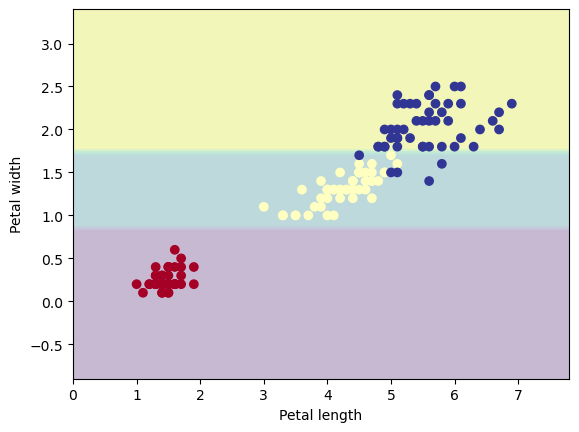

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

# Load the Iris dataset
iris = load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

# Train a decision tree classifier
tree = DecisionTreeClassifier(max_depth=2)
tree.fit(X, y)

# Create a mesh grid of points that cover the feature space
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Apply the trained model to each point on the mesh grid
Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision region
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
plt.show()


In [19]:
class ScratchDecisionTreeClassifierDepth2:
    """
    Scratch implementation of decision tree classifier of depth 2.

    Parameters
    ----------
    max_depth : int
        Maximum depth of the decision tree.
        
    Attributes
    ----------
    tree : dict
        Decision tree stored in a dictionary format.
        
    """
    
    def __init__(self, max_depth):
        # Record hyperparameters as attributes
        self.max_depth = max_depth
        
        # Initialize variables
        self.tree = {}
        self.feature_indices = []
        self.num_classes = 0
        self.num_features = 0
        
    def fit(self, X, y):
        """
        Fit the decision tree classifier to the training data.
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            Training data.
            
        y : ndarray, shape (n_samples,)
            Target values.
            
        """
        pass
        
    def predict(self, X):
        """
        Predict class labels for samples in X.
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            Samples to predict.
        
        Returns
        -------
        y_pred : ndarray, shape (n_samples,)
            Predicted class labels.
            
        """
        pass


In [20]:
def gini(y):
    """
    Calculate the Gini impurity for a node.
    
    Parameters
    ----------
    y : ndarray, shape (n_samples,)
        Target values.
        
    Returns
    -------
    impurity : float
        Gini impurity.
        
    """
    _, counts = np.unique(y, return_counts=True)
    probs = counts / len(y)
    impurity = 1 - np.sum(probs ** 2)
    return impurity


In [23]:
def information_gain(parent, left, right):
    """
    Calculate the information gain of a split.
    
    Parameters
    ----------
    parent : ndarray, shape (n_samples,)
        Target values for the parent node.
        
    left : ndarray, shape (n_samples_left,)
        Target values for the left child node.
        
    right : ndarray, shape (n_samples_right,)
        Target values for the right child node.
        
    Returns
    -------
    gain : float
        Information gain.
        
    """
    # Calculate impurity of parent node
    parent_impurity = gini(parent)
    
    # Calculate impurity of left child node
    left_impurity = gini(left)
    
    # Calculate impurity of right child node
    right_impurity = gini(right)
    
    # Calculate total number of samples
    n = len(parent)
    
    # Calculate total number of samples in left and right child nodes
    n_left = len(left)
    n_right = len(right)
    
    # Calculate information gain
    gain = parent_impurity - ((n_left / n) * left_impurity) - ((n_right / n) * right_impurity)
    
    return gain



In [24]:
import numpy as np
from collections import Counter

class ScratchDecesionTreeClassifierDepthInf:
    """
    A decision tree classifier with unlimited depth.

    Parameters
    ----------
    max_depth : int, optional (default=None)
        The maximum depth of the decision tree. If None, the tree will be grown until all leaf nodes have
        Gini impurity of 0.
    random_state : int, optional (default=None)
        Seed of the random number generator for reproducibility.

    Attributes
    ----------
    tree_ : dict
        The decision tree represented as a nested dictionary where each non-leaf node is a dictionary with
        the following keys:
        - 'feature_index': the index of the feature that is used for splitting
        - 'threshold': the threshold value for splitting on the feature
        - 'left': the dictionary representing the left subtree
        - 'right': the dictionary representing the right subtree
        Each leaf node is represented by the class label.
    """

    def __init__(self, max_depth=None, random_state=None):
        self.max_depth = max_depth
        self.random_state = random_state
        self.tree_ = None
        self.classes_ = None
        self.feature_indices_ = None

    def fit(self, X, y):
        """
        Build a decision tree classifier from the training set (X, y).

        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The input data.
        y : array-like, shape (n_samples,)
            The target values.

        Returns
        -------
        self : object
            Returns an instance of self.
        """
        self.classes_, y = np.unique(y, return_inverse=True)
        self.feature_indices_ = np.arange(X.shape[1])
        rng = np.random.RandomState(self.random_state)
        self.tree_ = self._build_tree(X, y, depth=1, rng=rng)
        return self

    def predict(self, X):
        """
        Predict class labels for the input data.

        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The input data.

        Returns
        -------
        y_pred : array-like, shape (n_samples,)
            The predicted class labels.
        """
        if self.tree_ is None:
            raise NotFittedError("Estimator not fitted, call `fit` first")
        y_pred = np.empty(len(X), dtype=self.classes_.dtype)
        for i, x in enumerate(X):
            node = self.tree_
            while isinstance(node, dict):
                if x[node['feature_index']] <= node['threshold']:
                    node = node['left']
                else:
                    node = node['right']
            y_pred[i] = node
        return self.classes_[y_pred]

    def _build_tree(self, X, y, depth, rng):
        """
        Build a decision tree classifier from the training set (X, y).

        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The input data.
        y : array-like, shape (n_samples,)
            The target values.
        depth : int
            The current depth of the decision tree.
        rng : np.random.RandomState
            Random number generator for selecting feature indices.

        Returns
        -------
        tree : dict or int
            The decision tree represented as a nested dictionary (if it is a non-leaf node) or an integer
            (if it is a leaf node).
        """
        if depth == self.max_depth:
            return self._leaf
